<a href="https://colab.research.google.com/github/Hou-jing/deep-learning_HW-liuxinfeng-teacher-/blob/main/%E6%89%8B%E5%86%99%E6%95%B0%E5%AD%97%E8%AF%86%E5%88%AB%E6%A8%A1%E5%9E%8B%E6%9E%B6%E6%9E%84%E4%BA%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
	import torch
	import torchvision
	from torch.utils.data import DataLoader
	import torch.nn as nn
	import torch.nn.functional as F
	import torch.optim as optim
	from torch.optim import lr_scheduler
	import matplotlib.pyplot as plt
	from PIL import Image
	import matplotlib.image as image
	import cv2
	import os


In [2]:
#调用GPU
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.empty_cache()


cuda


In [3]:
#初始化变量
n_epochs = 8 #训练次数
batch_size_train = 240 #训练的 batch_size
batch_size_test = 1000 #测试的 batch_size
learning_rate = 0.001 # 学习率
momentum = 0.5 # 在梯度下降过程中解决mini-batch SGD优化算法更新幅度摆动大的问题，使得收敛速度更快
log_interval = 10 # 操作间隔
random_seed = 2 # 随机种子，设置后可以得到稳定的随机数
torch.manual_seed(random_seed)


In [ ]:
#导入训练集并增强数据
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./mnist/', train=True, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.RandomAffine(degrees = 0,translate=(0.1, 0.1)),
                                   torchvision.transforms.RandomRotation((-10,10)),#将图片随机旋转（-10,10）度
                                   torchvision.transforms.ToTensor(),# 将PIL图片或者numpy.ndarray转成Tensor类型
                                   torchvision.transforms.Normalize((0.1307,), (0.3081,))])
                              ),
    batch_size=batch_size_train, shuffle=True,num_workers=4, pin_memory=True) # shuffle如果为true,每个训练epoch后，会将数据顺序打乱


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


对图像进行仿射变换，仿射变换是二维的线性变换，由五种基本原子变换构成，分别是旋转、平移、缩放、错切和翻转。

degrees：旋转角度设置
translate：平移区间设置，如（ａ，ｂ），ａ设置宽(width)，ｂ设置高(height)。
图像在宽维度平移的区间为　-img_width * a < dx < img_width * a　。
scale：缩放比例（以面积为单位）
fill_colore：一种填充颜色设置。
shear：错切角度设置，有水平错切和锤子错切。
若为ａ，则仅在ｘ轴错切，错切角度在（－ａ，ａ）之间
若为（ａ，ｂ），则ａ设置ｘ轴角度，ｂ设置ｙ的角度。
若为（ａ，ｂ，ｃ，ｄ），则ａ，ｂ设置ｘ轴角度，ｃ，ｄ设置ｙ轴角度。
resample：采样方式，有NEAREST、BILINEAR 、BICUBIC。
fill_color：填充的颜色
————————————————
版权声明：本文为CSDN博主「NotFound1911」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。
原文链接：https://blog.csdn.net/qq_24739717/article/details/102743691

In [ ]:
#导入测试集
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./mnist/', train=False, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize((0.1307,), (0.3081,))])
                              ),
    batch_size=batch_size_test, shuffle=True,num_workers=4, pin_memory=True)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# 用 enumerate 加载测试集
examples = enumerate(test_loader)
# 获取一个 batch
batch_idx, (example_data, example_targets) = next(examples)
# 查看 batch 数据，有10000张图像的标签，tensor 大小为 [1000, 1, 28, 28]
# 即图像为 28 * 28， 1个颜色通道（灰度图）， 1000张图像
#print(example_targets)
#print(example_data.shape)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


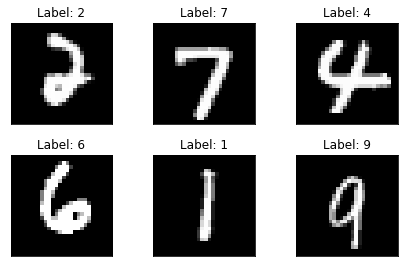

In [ ]:
#查看部分图片
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)# 创建 subplot
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Label: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()


In [4]:
#model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Convolution layer 1 (（w - f + 2 * p）/ s ) + 1
        self.conv1 = nn.Conv2d(in_channels = 1 , out_channels = 32, kernel_size = 5, stride = 1, padding = 0 )
        self.relu1 = nn.ReLU()
        self.batch1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(in_channels =32 , out_channels = 32, kernel_size = 5, stride = 1, padding = 0 )
        self.relu2 = nn.ReLU()
        self.batch2 = nn.BatchNorm2d(32)
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv1_drop = nn.Dropout(0.25)

        # Convolution layer 2
        self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 0 )
        self.relu3 = nn.ReLU()
        self.batch3 = nn.BatchNorm2d(64)
        
        self.conv4 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = 0 )
        self.relu4 = nn.ReLU()
        self.batch4 = nn.BatchNorm2d(64)
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv2_drop = nn.Dropout(0.25)

        # Fully-Connected layer 1
        
        self.fc1 = nn.Linear(576,256)
        self.fc1_relu = nn.ReLU()
        self.dp1 = nn.Dropout(0.5)
        
        # Fully-Connected layer 2
        self.fc2 = nn.Linear(256,10)
                
    def forward(self, x):
        # conv layer 1 的前向计算，3行代码
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.batch1(out)
        
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.batch2(out)
        
        out = self.maxpool1(out)
        out = self.conv1_drop(out)

        # conv layer 2 的前向计算，4行代码
        out = self.conv3(out)
        out = self.relu3(out)
        out = self.batch3(out)
        
        out = self.conv4(out)
        out = self.relu4(out)
        out = self.batch4(out)
        
        out = self.maxpool2(out)
        out = self.conv2_drop(out)

        #Flatten拉平操作
        out = out.view(out.size(0),-1)

        #FC layer的前向计算（2行代码）
        out = self.fc1(out)
        out = self.fc1_relu(out)
        out = self.dp1(out)
        
        out = self.fc2(out)

        return F.log_softmax(out,dim = 1)


In [5]:
# 实例化一个网络
network = CNNModel()
from torchsummary import summary
summary(network,(1, 28, 28), device="cpu")
network.to(device)
#调用权值初始化函数

# 设置优化器，用stochastic gradient descent，设置学习率，设置momentum
#optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
#optimizer = optim.Adam(network.parameters(), lr=learning_rate)
optimizer = optim.RMSprop(network.parameters(),lr=learning_rate,alpha=0.99,momentum = momentum)
#设置学习率梯度下降，如果连续三个epoch测试准确率没有上升，则降低学习率
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True, threshold=0.00005, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]             832
              ReLU-2           [-1, 32, 24, 24]               0
       BatchNorm2d-3           [-1, 32, 24, 24]              64
            Conv2d-4           [-1, 32, 20, 20]          25,632
              ReLU-5           [-1, 32, 20, 20]               0
       BatchNorm2d-6           [-1, 32, 20, 20]              64
         MaxPool2d-7           [-1, 32, 10, 10]               0
           Dropout-8           [-1, 32, 10, 10]               0
            Conv2d-9             [-1, 64, 8, 8]          18,496
             ReLU-10             [-1, 64, 8, 8]               0
      BatchNorm2d-11             [-1, 64, 8, 8]             128
           Conv2d-12             [-1, 64, 6, 6]          36,928
             ReLU-13             [-1, 64, 6, 6]               0
      BatchNorm2d-14             [-1, 6

In [ ]:
#定义存储数据的列表
train_losses = []
train_counter = []
train_acces = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
test_acces = []


In [ ]:
# 定义训练函数
def train(epoch):
    
    network.train() # 将网络设为 training 模式
    train_correct = 0
    # 对一组 batch 
    for batch_idx, (data, target) in enumerate(train_loader): 
        # 通过enumerate获取batch_id, data, and label
        # 1-将梯度归零
        optimizer.zero_grad()
        
        # 2-传入一个batch的图像，并前向计算
        # data.to(device)把图片放入GPU中计算
        output = network(data.to(device))
        
        # 3-计算损失
        loss = F.nll_loss(output, target.to(device))
        
        # 4-反向传播
        loss.backward()
        
        # 5-优化参数
        optimizer.step()
        #exp_lr_scheduler.step()
        
        train_pred = output.data.max(dim=1, keepdim=True)[1] # 取 output 里最大的那个类别, 
             # dim = 1表示去每行的最大值，[1]表示取最大值的index，而不去最大值本身[0]    

        train_correct += train_pred.eq(target.data.view_as(train_pred).to(device)).sum() # 比较并求正确分类的个数
        #打印以下信息：第几个epoch，第几张图像， 总训练图像数, 完成百分比，目前的loss
        print('\r 第 {} 次 Train Epoch: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()),end = '')

        # 每第10个batch (log_interval = 10)
        if batch_idx  % log_interval == 0:
            #print(batch_idx)
            # 把目前的 loss加入到 train_losses,后期画图用
            train_losses.append(loss.item())
            # 计数
            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
    
    train_acc = train_correct / len(train_loader.dataset)
    train_acces.append(train_acc.cpu().numpy().tolist())
    print('\tTrain Accuracy:{:.2f}%'.format(100. * train_acc))


In [ ]:
# 定义测试函数
def test(epoch):
    network.eval() # 将网络设为 evaluating 模式
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data.to(device)) # 传入这一组 batch，进行前向计算
            #test_loss += F.nll_loss(output, target, size_average=False).item()
            test_loss += F.nll_loss(output, target.to(device), reduction='sum').item()

            pred = output.data.max(dim=1, keepdim=True)[1] # 取 output 里最大的那个类别, 
             # dim = 1表示去每行的最大值，[1]表示取最大值的index，而不去最大值本身[0]    

            correct += pred.eq(target.data.view_as(pred).to(device)).sum() # 比较并求正确分类的个数
    acc = correct / len(test_loader.dataset)# 平均测试准确率
    test_acces.append(acc.cpu().numpy().tolist())
    
    test_loss /= len(test_loader.dataset) # 平均 loss， len 为 10000
    test_losses.append(test_loss) # 记录该 epoch 下的 test_loss
    
    #保存测试准确率最大的模型
    if test_acces[-1] >= max(test_acces):
        # 每个batch训练完后保存模型 
        torch.save(network.state_dict(), './model02.pth')

        # 每个batch训练完后保存优化器
        torch.save(optimizer.state_dict(), './optimizer02.pth')
    
    # 打印相关信息 如：Test set: Avg. loss: 2.3129, Accuracy: 1205/10000 (12%)
    print('\r Test set \033[1;31m{}\033[0m : Avg. loss: {:.4f}, Accuracy: {}/{}  \033[1;31m({:.2f}%)\033[0m\n'\
          .format(epoch,test_loss, correct,len(test_loader.dataset),100. * acc),end = '') 


In [ ]:
### 训练！！！ 并在每个epoch之后测试 ###
###################################################
# 根据epoch数正式训练并在每个epoch训练结束后测试
for epoch in range(1, n_epochs + 1):
    scheduler.step(200)
    train(epoch)
    test(epoch)
#输入最后保存的模型的准确率，也就是最高测试准确率
print('\n\033[1;31mThe network Max Avg Accuracy : {:.2f}%\033[0m'.format(100. * max(test_acces)))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 第 1 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.156028	Train Accuracy:91.34%
 Test set 1 : Avg. loss: 0.0375, Accuracy: 9896/10000  (98.96%)
 第 2 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.063662	Train Accuracy:96.69%
 Test set 2 : Avg. loss: 0.0267, Accuracy: 9920/10000  (99.20%)
 第 3 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.175545	Train Accuracy:97.33%
 Test set 3 : Avg. loss: 0.0250, Accuracy: 9925/10000  (99.25%)
 第 4 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.051297	Train Accuracy:97.72%
 Test set 4 : Avg. loss: 0.0287, Accuracy: 9906/10000  (99.06%)
Epoch     5: reducing learning rate of group 0 to 5.0000e-04.
 第 5 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.035339	Train Accuracy:98.29%
 Test set 5 : Avg. loss: 0.0151, Accuracy: 9956/10000  (99.56%)
 第 6 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.043971	Train Accuracy:98.44%
 Test set 6 : Avg. loss: 0.0162, Accuracy: 9944/10000  (99.44%)
 第 7 次 Train Epoch: [60000/60000 (100%)]	Loss: 0.087723	Train Accuracy:98.51%
 Test se

In [ ]:
#可视化
fig = plt.figure(figsize=(15,5))#将画图窗口横向放大15倍，纵向放大5倍
ax1 = fig.add_subplot(121)
#训练损失
ax1.plot(train_counter, train_losses, color='blue')
#测试损失
plt.scatter(test_counter[:len(test_losses)], test_losses, color='red')
#图例
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.title('Train & Test Loss')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

plt.subplot(122)
#最大测试准确率的索引
max_test_acces_epoch = test_acces.index(max(test_acces))
#最大值保留4位小数，四舍五入
max_test_acces = round(max(test_acces),4)
#训练准确率
plt.plot([epoch+1 for epoch in range(n_epochs) ], train_acces, color='blue')
#测试准确率
plt.plot([epoch+1 for epoch in range(n_epochs) ], test_acces[1:], color='red')

plt.plot(max_test_acces_epoch,max_test_acces,'ko') #最大值点

show_max='  ['+str(max_test_acces_epoch )+' , '+str(max_test_acces)+']'
#最大值点坐标显示
plt.annotate(show_max,xy=(max_test_acces_epoch,max_test_acces), 
             xytext=(max_test_acces_epoch,max_test_acces))

plt.legend(['Train acc', 'Test acc'], loc='lower right')
plt.title('Train & Test Accuracy')
#plt.ylim(0.8, 1)
plt.xlabel('number of training epoch')
plt.ylabel('negative log likelihood acc')
plt.show()
